# **Required Downloads**

In [255]:
!pip install -q transformers
!pip install -q contractions
!pip install -q autocorrect
!pip install -q tensorflow

# **Required Imports**

In [256]:

from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers import RobertaTokenizer,TFRobertaForSequenceClassification
from transformers import XLNetTokenizer, TFXLNetForSequenceClassification
from transformers import ElectraTokenizer,TFElectraForSequenceClassification
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification,TFPreTrainedModel

import time

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix , classification_report
import pandas as pd
import seaborn as sns

import tensorflow as tf
import json

import numpy as np
import pandas as pd


import os
import re

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize

import contractions
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score
from autocorrect import Speller



# **Data Prepration**

## Getting Data
- Importing Data
- Loading Data

### Importing Data 
- The following cell is importing data from google drive and storing the files to /home/Emotiondata directory.
- Data Source: 
> https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp

In [260]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [261]:
DataDir = '/home/EmotionData/'
!mkdir /home/EmotionData
!unzip /content/drive/MyDrive/archive.zip 
!mv /content/*.txt /home/EmotionData

mkdir: cannot create directory ‘/home/EmotionData’: File exists
Archive:  /content/drive/MyDrive/archive.zip
  inflating: test.txt                
  inflating: train.txt               
  inflating: val.txt                 


### Loading Data
- The Following cell loads train, validation and test data to variables 
- Shows how the data looks from reading the file.
- Used Sources: 
>https://stackoverflow.com/questions/21546739/load-data-from-txt-with-pandas

In [262]:
def readDataEmotionData1(dataPath):
  data = pd.read_csv(DataDir+dataPath, sep=";", header=None, names = ['Text','Label'])
  return data;

trainData = readDataEmotionData1('train.txt')
valData = readDataEmotionData1('val.txt')
testData = readDataEmotionData1('test.txt')
# Shows how the data looks in the padas DataFrame after loading 
trainData.head()

,Text,Label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


## Exploring Data


In [263]:
# The following function adds length coloum to pandas Dataframe
def addTextLength(dataFrame):
  lengthData = []
  for i in dataFrame['Text']:
    lengthData.append(len(i))
  dataFrame=dataFrame.assign(Length=lengthData)
  return dataFrame
trainData = addTextLength(trainData)
valData = addTextLength(valData)
testData = addTextLength(testData)
valData.head()

,Text,Label,Length
0,im feeling quite sad and sorry for myself but ...,sadness,69
1,i feel like i am still looking at a blank canv...,sadness,70
2,i feel like a faithful servant,love,30
3,i am just feeling cranky and blue,anger,33
4,i can have for a treat or if i am feeling festive,joy,49


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


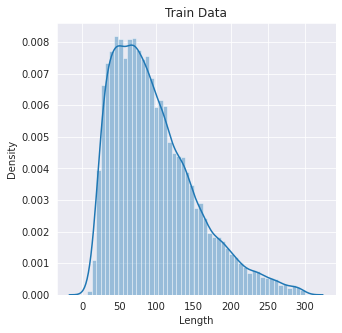

In [264]:
# This shows the distrubution of the number of characters length of the Text.
def plotDestrubrition(data,name):
  sns.set_style('darkgrid')
  plt.figure(figsize=(5,5))
  plt.title(name)
  sns.distplot(data)
plotDestrubrition(trainData['Length'],'Train Data')

In [265]:
maxSentanceLength = 300
trainData.describe()

,Length
count,16000.000000
mean,96.845812
std,55.904953
min,7.000000
25%,53.000000
50%,86.000000
75%,129.000000
max,300.000000


## Text Pre-Processing
- Decontraction
- Spell check


### Decontraction 
- Having contractions tends to drop vowels from words in English. By Decotracting words in the text, it standardizas the text which could be very useful while traning Text Classfication Model.

- Source:  
`https://www.geeksforgeeks.org/nlp-expand-contractions-in-text-processing/`<br />
`https://medium.com/analytics-vidhya/natural-language-processing-for-developers-912ee0fda979`





In [268]:
# This requries  contractions package.
# This Function accepts a Pandas Data Frame with sentences in column titled 'Text'.
def Decontracted(DataFrame):
  # This loop enumerates, giving 'i' being the index of the sentence which is denoted by 'text'.
  for i, text in enumerate(DataFrame['Text']):
    DataFrame['Text'][i] = contractions.fix(text)
  return DataFrame

# Calling Decontracted function on all three Datasets
trainData = Decontracted(trainData)
valData = Decontracted(valData)
testData = Decontracted(testData)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Checking Spelling 

- Training and Validation text containing misspelled words might not help the model recognize a pattern since a different token would be assigned during tokenization.
> **Note**: This will take really long time, remove or comment it if needed.

In [269]:
# This requires autocorrect package as Speller.
# This Function accepts a Pandas Data Frame with sentences in column titled 'Text'.
def SpellCheck(DataFrame):
  spell = Speller(lang='en')
  for i, text in enumerate(DataFrame['Text']):
      DataFrame['Text'][i] = str(spell(text))
  return DataFrame

# Calling SpellCheck function on all three Datasets
trainData = SpellCheck(trainData)
valData = SpellCheck(valData)
testData = SpellCheck(testData)

## Text Processing
- Labels Enconding
- Text Tokenization


### Label Encoding
- When making this model, we tried two methods for label encoding, those being one-hot encoding, and assigning an arbitrary integer value to each of the text classifiers.

- While training and testing the model, we found out that there was no substantial difference in accuracy. Therefore, we choose the second method with assigning an arbitrary integer value.

- In the dataset we are using there are following 6 classifiers and the corresponding listed below. <br />
` Anger: 0 
  Fear: 1
  Joy: 2
  Love: 3
  Sadness: 4
  Surprise: 5`
> **Note**: If you would like to use one-hot encoding instead of what we were using, return 'LabelsNames' instead of 'labels' in the LabelEncoding function. You may also need to change the loss function from SparseCategoricalCrossentropy to CategoricalCrossentropy in the model architecture.

In [270]:
# If one-hot encoding is being used requires CountVectorizer and TfidfVectorizer packages from sklearner.
# This Function accepts a Pandas Data Frame with sentences classifications in column titled 'Label'
def LabelEncoding(DataFrame):
  labels = []
  encodeVectorizer = CountVectorizer(analyzer = "word", tokenizer = None,lowercase=True, preprocessor = None, stop_words = None)
  encodedLabels = encodeVectorizer.fit_transform(DataFrame['Label']).toarray()
  LabelsNames = list(encodeVectorizer.get_feature_names())
  for i in DataFrame['Label']:
    labels.append((list(LabelsNames).index(i)))
  return labels,LabelsNames

# Calling LabelEncoding function on all three Datasets
encodedTrainLabels,TrainLabelFeatureNames = LabelEncoding(trainData)
encodedValLabels,ValLabelFeatureNames = LabelEncoding(valData)
encodedTestLabels,TestLabelFeatureNames = LabelEncoding(testData)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Text Tokenization
- With the use of AutoTokenizer from hugging face's python package called transformers, we are able to tokenize list of text sentences using the pretrained tokens from a given transformer model.
- The Hugging face's tokenizer has parameters for custom padding length which we used while making this model.
- The TextEncoding Function returns a tensor_slices dataset containing text encodings and their corresponding labels as in a format tensorflow requires with a custom tranning batch size.

> **Note**: Tokenization could be accomplished also using pre-trained model specfic tokenizer insted of AutoTokenizer, ex. AutoTokenizer.from_pretrained('bert-base-uncased') which return the same tokenizer as BertTokenizer.from_pretrained('bert-base-uncased')


In [271]:
# This Function requires AutoTokenizer packages from transformers and import tensorflow as tf.
def TextEncoding(
                 # The model specific tokenizer ex. 'bert-base-uncased'
                 tokenizerType,
                 # The list of data containing Text 
                 dataTextList, 
                 # The list of Corresponding Classification of dataTextList in one-hot or other encoding
                 LabelList, 
                 # The Traing Batch Size.
                 batchSize,
                 # The Shuffling Parameter
                 shufflingParameter,
                 # The Padding Length
                 maxLen):
  tokenizer = AutoTokenizer.from_pretrained(tokenizerType)
  
  textEncodings = tokenizer(dataTextList,
                            truncation=True, 
                            max_length = maxLen,
                            padding="max_length")
  
  dataset = tf.data.Dataset.from_tensor_slices((
    dict(textEncodings),
    LabelList
    ))
  dataset = dataset.shuffle(shufflingParameter).batch(batchSize)
  return dataset,tokenizer

# **Model Bulding and Training**

In [275]:
!mkdir /models/
!mkdir /models/Stats/
timeData = pd.DataFrame(columns= ['Training(min) ', 'Evalution(min)']).rename_axis('Models', axis=1)


In [276]:
def CreateModel(model,
                numLabels,
                maxSentanceLength,
                input_ids,
                mask):
  embeddings = model(input_ids,mask)[0]
  layer = tf.keras.layers.Dense(1000,activation='relu')(embeddings)
  layer = tf.keras.layers.BatchNormalization()(layer)
  outputLayer = tf.keras.layers.Dense(6,activation='softmax',name='outputs')(layer)
  testModel = tf.keras.Model(inputs=[input_ids,mask],outputs=outputLayer)
  return testModel

In [277]:
def plotEpochs(hist,
               histKeys,
               Title,
               Ylabel,
               Xlabel = "Epochs",
               savePlotPath = ""):
  legends = []
  for i in histKeys:
    plt.plot(hist.history[i])
    legends.append(i)
  plt.title(Title)
  plt.ylabel(Ylabel)
  plt.xlabel(Xlabel)
  plt.legend(legends)
  if len(savePlotPath) > 0:
    plt.savefig(savePlotPath,format='eps',dpi=1200)
  plt.show()



In [278]:
'''
While Trying make custom matrices, I found this post in which they have coded what I was attempting.
**Note** I changed the definition name for my own purpose
Source: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model 
'''
from keras import backend as K

def Recalls(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def Precision_Marco(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def F1_Macro(y_true, y_pred):
    precision = Precision_Marco(y_true, y_pred)
    recall = Recalls(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [279]:
def trainModel(
    # Default Parameters
    maxSentanceLength = 275,
    BatchSize = 16,
    shufflingParameter = 1000,
    Learning_rate=5e-5,
    Epochs=4,
    numLabels = len(encodedTrainLabels),
    ModelName = 'bert-base-uncased',
    ModelMetrics = ['accuracy'],
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    ModelTrainData = list(trainData['Text']),
    TrainLabels = encodedTrainLabels,
    ModelValData = list(valData['Text']),
    ValLabels = encodedValLabels):
  valDataSet,tokenizer = TextEncoding(ModelName,
                                      ModelValData,
                                      ValLabels,
                                      BatchSize,
                                      shufflingParameter,
                                      maxSentanceLength)
  
  trainDataSet,tokenizer = TextEncoding(ModelName,
                                        ModelTrainData,
                                        TrainLabels,
                                        BatchSize,
                                        shufflingParameter,
                                        maxSentanceLength)

  
  input_ids = tf.keras.layers.Input(shape=(maxSentanceLength,),name="input_ids", dtype='int32')
  mask = tf.keras.layers.Input(shape=(maxSentanceLength,),name="attention_mask",dtype='int32')
  modelPreTrianed = TFAutoModelForSequenceClassification.from_pretrained(ModelName,
                                                               num_labels=6)
  model = CreateModel(modelPreTrianed,
                      numLabels,
                      maxSentanceLength,
                      input_ids = input_ids,
                      mask = mask)
  model.compile(optimizer=optimizer, 
                loss=loss, 
                metrics=ModelMetrics)
  StartTime = time.time()
  hist = model.fit(trainDataSet,
          epochs=Epochs,
          batch_size=BatchSize,
          validation_data =valDataSet)
  EndTime = time.time()
  TrainingTime = (EndTime-StartTime)/60
  return tokenizer,hist,model, modelPreTrianed,TrainingTime



In [280]:
def saveModelWeights(model,
                     path):
  model.save_weights(path)
  print('The Model Saved')

def saveTrasformerTokenizer(tokenizer,
                            path):
  tokenizer.save_pretrained(path)
  print('The Tokenizer Saved')

def savePreTrainedTransformerModel(model,
                                   path):
  model.save_pretrained(path)
  print('The PreTrained Transformer Model Saved')

  

In [281]:
def doTrainningModel(ModelName,
                     ModelType):
  Tokenizer,history,model,PreTrainedModel,TrainningTime = trainModel(ModelMetrics = ['accuracy',F1_Macro],
                                                                     ModelName=ModelType)
  plotEpochs(hist = history,
            histKeys = ['accuracy','val_accuracy','F1_Macro','val_F1_Macro'],
            Title = ModelName +" Accuracy Graph",
            Ylabel = "Accuracy",
            savePlotPath = '/models/'+ModelName+'/Accuracy.epi')
  plotEpochs(hist = history,
            histKeys = ['loss','val_loss'],
            Title = ModelName+ "Loss Graph",
            Ylabel = "Loss",
            savePlotPath = "/models/"+ModelName+"/Loss.epi" )
  saveModelWeights(model,
                  '/models/'+ModelName+'/'+ModelName+'Weights.h5')

  savePreTrainedTransformerModel(PreTrainedModel,
                                '/models/'+ModelName+'/'+ModelName+'PreTrainedModel')
  saveTrasformerTokenizer(Tokenizer,
                          '/models/'+ModelName+'/'+ModelName+'Tokenizer/')
  timeData.loc[ModelName] = [TrainningTime,'NaN']
  timeData.to_csv('/models/Stats/TimeData.csv',index=True,index_label='Models')
  model.summary()

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1000/1000 [==============================] - 607s 587ms/step - loss: 0.4636 - accuracy: 0.8475 - F1_Macro: 1.2438 - val_loss: 0.3323 - val_accuracy: 0.9090 - val_F1_Macro: 1.0184
Epoch 2/4
1000/1000 [==============================] - 583s 583ms/step - loss: 0.1834 - accuracy: 0.9333 - F1_Macro: 1.0020 - val_loss: 0.1687 - val_accuracy: 0.9295 - val_F1_Macro: 0.9983
Epoch 3/4
1000/1000 [==============================] - 583s 583ms/step - loss: 0.1479 - accuracy: 0.9423 - F1_Macro: 0.9943 - val_loss: 0.1744 - val_accuracy: 0.9350 - val_F1_Macro: 0.9993
Epoch 4/4
1000/1000 [==============================] - 582s 582ms/step - loss: 0.1355 - accuracy: 0.9466 - F1_Macro: 0.9912 - val_loss: 0.2098 - val_accuracy: 0.9300 - val_F1_Macro: 0.9886


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


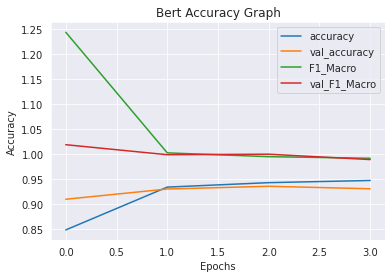

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


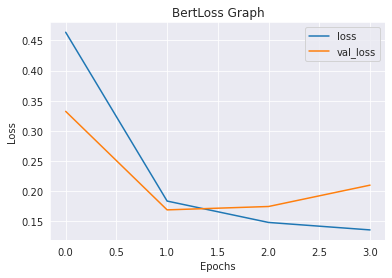

The Model Saved
The PreTrained Transformer Model Saved
The Tokenizer Saved
Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 275)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 275)]        0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  109486854  ['input_ids[0][0]',              
 ation_14 (TFBertForSequenceCla  rOutput(loss=None,               'attention_mask[0][0]']         
 ssification)                   logits=(None, 6),                                                 
                

In [282]:
# Bert Model
!mkdir /models/Bert
!mkdir /models/Bert/BertPreTrainedModel/
!mkdir /models/Bert/BertTokenizer/

doTrainningModel('Bert',
                 'bert-base-uncased')

In [283]:
timeData = pd.read_csv('/models/Stats/TimeData.csv',index_col=0)
timeData

,Training(min),Evalution(min)
Models,,
Bert,39.898933,NaN


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_transform', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_989']
You should probably TRAIN this model on a down-stream task to be able to use 

Epoch 1/4
1000/1000 [==============================] - 307s 297ms/step - loss: 0.5544 - accuracy: 0.8157 - F1_Macro: 1.3235 - val_loss: 0.2269 - val_accuracy: 0.9170 - val_F1_Macro: 1.0097
Epoch 2/4
1000/1000 [==============================] - 296s 296ms/step - loss: 0.1930 - accuracy: 0.9327 - F1_Macro: 1.0113 - val_loss: 0.2084 - val_accuracy: 0.9300 - val_F1_Macro: 0.9935
Epoch 3/4
1000/1000 [==============================] - 296s 296ms/step - loss: 0.1389 - accuracy: 0.9458 - F1_Macro: 0.9931 - val_loss: 0.1865 - val_accuracy: 0.9315 - val_F1_Macro: 0.9956
Epoch 4/4
1000/1000 [==============================] - 296s 296ms/step - loss: 0.1115 - accuracy: 0.9582 - F1_Macro: 0.9807 - val_loss: 0.2091 - val_accuracy: 0.9300 - val_F1_Macro: 0.9928


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


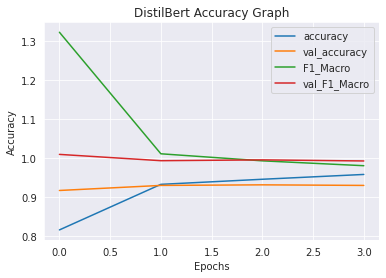

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


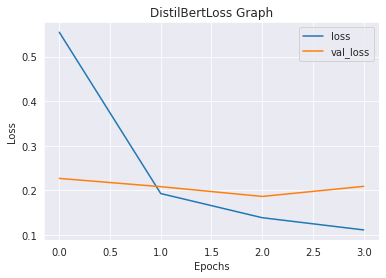

The Model Saved
The PreTrained Transformer Model Saved
The Tokenizer Saved
Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 275)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 275)]        0           []                               
                                                                                                  
 tf_distil_bert_for_sequence_cl  TFSequenceClassifie  66958086   ['input_ids[0][0]',              
 assification_3 (TFDistilBertFo  rOutput(loss=None,               'attention_mask[0][0]']         
 rSequenceClassification)       logits=(None, 6),                                                 
                

In [284]:
# DistilBert Model
!mkdir /models/DistilBert
!mkdir /models/DistilBert/DistilBertPreTrainedModel/
!mkdir /models/DistilBert/DistilBertTokenizer/

doTrainningModel('DistilBert',
                 'distilbert-base-uncased')

In [288]:
timeData = pd.read_csv('/models/Stats/TimeData.csv',index_col=0)
timeData

,Training(min),Evalution(min)
Models,,
Bert,39.898933,NaN
DistilBert,20.787233,NaN


mkdir: cannot create directory ‘/models/Roberta’: File exists
mkdir: cannot create directory ‘/models/Roberta/RobertaPreTrainedModel/’: File exists
mkdir: cannot create directory ‘/models/Roberta/RobertaTokenizer/’: File exists


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
1000/1000 [==============================] - 591s 576ms/step - loss: 0.5070 - accuracy: 0.8296 - F1_Macro: 1.3149 - val_loss: 0.2440 - val_accuracy: 0.9225 - val_F1_Macro: 0.9707
Epoch 2/4
1000/1000 [==============================] - 573s 573ms/step - loss: 0.2215 - accuracy: 0.9231 - F1_Macro: 1.0128 - val_loss: 0.1571 - val_accuracy: 0.9380 - val_F1_Macro: 0.9870
Epoch 3/4
1000/1000 [==============================] - 574s 574ms/step - loss: 0.1805 - accuracy: 0.9306 - F1_Macro: 1.0063 - val_loss: 0.1637 - val_accuracy: 0.9335 - val_F1_Macro: 0.9935
Epoch 4/4
1000/1000 [==============================] - 574s 574ms/step - loss: 0.1630 - accuracy: 0.9357 - F1_Macro: 1.0041 - val_loss: 0.1965 - val_accuracy: 0.9260 - val_F1_Macro: 1.0111


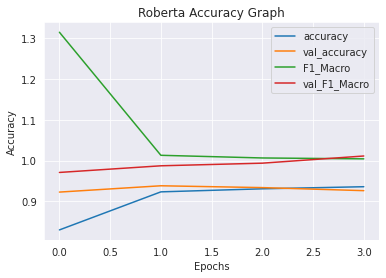

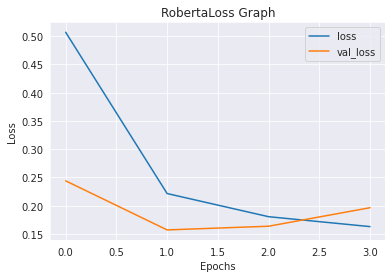

The Model Saved
The PreTrained Transformer Model Saved
The Tokenizer Saved
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 275)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 275)]        0           []                               
                                                                                                  
 tf_roberta_for_sequence_classi  TFSequenceClassifie  124650246  ['input_ids[0][0]',              
 fication (TFRobertaForSequence  rOutput(loss=None,               'attention_mask[0][0]']         
 Classification)                logits=(None, 6),                                                 
                   

<Figure size 432x288 with 0 Axes>

In [ ]:
# Roberta Model
!mkdir /models/Roberta
!mkdir /models/Roberta/RobertaPreTrainedModel/
!mkdir /models/Roberta/RobertaTokenizer/

doTrainningModel('Roberta',
                 'roberta-base')

In [286]:
timeData = pd.read_csv('/models/Stats/TimeData.csv',index_col=0)
timeData

,Training(min),Evalution(min)
Models,,
Bert,39.898933,NaN
DistilBert,20.787233,NaN


In [289]:
# Electra Model
!mkdir /models/Electra
!mkdir /models/Electra/ElectraPreTrainedModel/
!mkdir /models/Electra/ElectraTokenizer/

doTrainningModel('Electra',
                 'google/electra-small-discriminator')

mkdir: cannot create directory ‘/models/Electra’: File exists
mkdir: cannot create directory ‘/models/Electra/ElectraPreTrainedModel/’: File exists
mkdir: cannot create directory ‘/models/Electra/ElectraTokenizer/’: File exists


KeyboardInterrupt: ignored

In [ ]:
timeData = pd.read_csv('/models/Stats/TimeData.csv',index_col=0)
timeData

In [ ]:
# MobileBert Model
!mkdir /models/MobileBert
!mkdir /models/MobileBert/MobileBertPreTrainedModel/
!mkdir /models/MobileBert/MobileBertTokenizer/

doTrainningModel('MobileBert',
                 'google/mobilebert-uncased')

In [ ]:
timeData = pd.read_csv('/models/Stats/TimeData.csv',index_col=0)
timeData

In [290]:
!gsutil cp -r /models/Bert gs://emotion-models/
!gsutil cp -r /models/DistilBert gs://emotion-models/


Copying file:///models/Bert/BertWeights.h5 [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

Copying file:///models/Bert/Accuracy.epi [Content-Type=application/octet-stream]...
Copying file:///models/Bert/Loss.epi [Content-Type=application/octet-stream]...
Copying file:///models/Bert/BertPreTrainedModel/tf_model.h5 [Content-Type=

# **Model Validation**

In [274]:
# !gcloud auth login
# !gcloud config set project oval-tuner-326314
!gsutil cp -r /models/Stats gs://emotion-models/


Copying file:///models/Stats/DistilBertConfusionMatrix.eps [Content-Type=application/postscript]...
Copying file:///models/Stats/TimeData.csv [Content-Type=text/csv]...
Copying file:///models/Stats/RobertaConfusionMatrix.eps [Content-Type=application/postscript]...
Copying file:///models/Stats/BertConfusionMatrix.eps [Content-Type=application/postscript]...
- [4 files][230.2 KiB/230.2 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file:///models/Stats/ElectraConfusionMatrix.eps [Content-Type=application/postscript]...
Copying file:///models/Stats/MobileBertConfusionMatrix.eps [Content-Type=application/postscript]...
Copying file:///models/Stats/ThreshHoldStats.csv [Content-Type=text/csv]...
Copying file:///models/Stats/Model

In [138]:
class PredictEmotion:
  def __init__(self,
               modelName, 
               modelPath,
               modelPreTrainedPath,
               isTokenizerFast = False, 
               numLabels = 6,
               thrushHold = 0.3):
    self.modelPreTrainedPath = modelPreTrainedPath
    self.modelName = modelName
    self.modelPath = modelPath
    self.isTokenizerFast = isTokenizerFast
    self.numLabels = numLabels
    self.model = self.MakeModelArchitecture()
    self.loadModelWeights()
    self.tokenizer = self.makeTokenizer()
    self.spell = Speller(lang='en')
    self.emotionTypes = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise','other']
    self.thrushHold = thrushHold

  def MakeModelArchitecture(self):
    model = TFAutoModelForSequenceClassification.from_pretrained(self.modelPreTrainedPath, 
                                                                 local_files_only=True)

    input_ids = tf.keras.layers.Input(shape=(200,),name="input_ids", dtype='int32')
    mask = tf.keras.layers.Input(shape=(200,),name="attention_mask",dtype='int32')
    embeddings = model(input_ids,attention_mask=mask)[0]
    layer = tf.keras.layers.Dense(1000,activation='relu')(embeddings)
    layer = tf.keras.layers.BatchNormalization()(layer)
    outputLayer = tf.keras.layers.Dense(6,activation='softmax',name='outputs')(layer)
    ModelArchitecture = tf.keras.Model(inputs=[input_ids,mask],outputs=outputLayer)
    return ModelArchitecture

  def loadModelWeights(self):
    self.model.load_weights(self.modelPath)
  
  def makeTokenizer(self):
    return AutoTokenizer.from_pretrained(self.modelName)
  
  def TextPrepration(self,text):
    DecontractedText = contractions.fix(text)
    # SpelledText = str(self.spell(DecontractedText))
    textEncodings = self.tokenizer(DecontractedText,
                            truncation=True, 
                            max_length = 200,
                            padding="max_length", 
                            return_tensors='tf')
    return {
      'input_ids': tf.cast(textEncodings['input_ids'],tf.int32),
      'attention_mask': tf.cast(textEncodings['attention_mask'],tf.int32)}

  def PredictTextEmotion(self,text):
    prepratedText = self.TextPrepration(text)
    emotion = self.model.predict(prepratedText) 
    predictedEmotion = np.argmax(emotion)
    highestProb = emotion[0][predictedEmotion]
    if highestProb < self.thrushHold:
      return self.emotionTypes[len(self.emotionTypes)-1], self.thrushHold
    else:
      return self.emotionTypes[predictedEmotion],highestProb


In [52]:
def predictEmotionTestData(predict,testDataSet):
  predictedLabels = []
  startTime = time.time()
  for i in testDataSet:
    # print(i)
    emotion,prob = predict.PredictTextEmotion(i)
    predictedLabels.append(emotion)
  endTime = time.time()
  elapasedTime = (endTime-startTime)/60
  return elapasedTime,predictedLabels


In [246]:
def appendF1ModelScores(trueEmotionLabels,
                        predictedEmotionLabels,
                        F1ScoresDataFrame,
                        AppendingModelName):
  f1Report = classification_report(trueEmotionLabels, predictedEmotionLabels,output_dict=True)
  f1_scores = pd.DataFrame(f1Report).transpose()
  f1_scores = f1_scores.loc[:,['f1-score']]
  if len(list(f1_scores['f1-score'][:])) == 10:
    scores = np.delete((list(f1_scores['f1-score'][:])),4)
  else:
    scores = list(f1_scores['f1-score'][:])
  F1ScoresDataFrame[AppendingModelName] = scores
  return F1ScoresDataFrame

In [103]:
# Source code credit for this function: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
def print_confusion_matrix(confusion_matrix, 
                           class_names,
                           ModelTitle,
                           savePath = "" ,
                           figsize = (10,7), 
                           fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True,cmap='coolwarm', linecolor='white', fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')
    plt.title(ModelTitle)
    plt.savefig(savePath,format='eps')


In [184]:
F1ModelScores = pd.DataFrame(index=['anger', 'fear', 'joy', 'love' ,'sadness', 'surprise', 'accuracy',
       'macro avg', 'weighted avg']).rename_axis('Emotion', axis=1)

In [188]:
labels = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']
testLabels = list(testData['Label'])

In [162]:
threshHoldStats = pd.DataFrame(index=['30%','50%','70%']).rename_axis('Threshold', axis=1)

In [181]:
def doThresholds(modelName,
                 testData,
                 testDataTrueLabels,
                 Threshold):
  predictClass = PredictEmotion('/models/'+modelName+'/'+modelName+'Tokenizer/',
                              '/models/'+modelName+'/'+modelName+'Weights.h5',
                              '/models/'+modelName+'/'+modelName+'PreTrainedModel/',
                               thrushHold = Threshold)
  elapasedTime,predVal = predictEmotionTestData(predictClass,testData)
  f1Score = f1_score(testDataTrueLabels, predVal, average='macro')
  return elapasedTime,predVal,f1Score
  

In [ ]:
# Bert
Bert_elapasedTime_30,Bert_predVal_30,Bert_f1Score_30= doThresholds('Bert',
             list(testData['Text']),
             list(testData['Label']),
             0.3);
Bert_elapasedTime_50,Bert_predVal_50,Bert_f1Score_50= doThresholds('Bert',
             list(testData['Text']),
             list(testData['Label']),
             0.5);
Bert_elapasedTime_70,Bert_predVal_70,Bert_f1Score_70= doThresholds('Bert',
             list(testData['Text']),
             list(testData['Label']),
             0.7);
#DistilBert

DistilBert_elapasedTime_30,DistilBert_predVal_30,DistilBert_f1Score_30= doThresholds('DistilBert',
             list(testData['Text']),
             list(testData['Label']),
             0.3);
DistilBert_elapasedTime_50,DistilBert_predVal_50,DistilBert_f1Score_50= doThresholds('DistilBert',
             list(testData['Text']),
             list(testData['Label']),
             0.5);
DistilBert_elapasedTime_70,DistilBert_predVal_70,DistilBert_f1Score_70= doThresholds('DistilBert',
             list(testData['Text']),
             list(testData['Label']),
             0.7);
#Roberta

Roberta_elapasedTime_30,Roberta_predVal_30,Roberta_f1Score_30= doThresholds('Roberta',
             list(testData['Text']),
             list(testData['Label']),
             0.3);
Roberta_elapasedTime_50,Roberta_predVal_50,Roberta_f1Score_50= doThresholds('Roberta',
             list(testData['Text']),
             list(testData['Label']),
             0.5);
Roberta_elapasedTime_70,Roberta_predVal_70,Roberta_f1Score_70= doThresholds('Roberta',
             list(testData['Text']),
             list(testData['Label']),
             0.7);
# MobileBert

MobileBert_elapasedTime_30,MobileBert_predVal_30,MobileBert_f1Score_30= doThresholds('MobileBert',
             list(testData['Text']),
             list(testData['Label']),
             0.3);
MobileBert_elapasedTime_50,MobileBert_predVal_50,MobileBert_f1Score_50= doThresholds('MobileBert',
             list(testData['Text']),
             list(testData['Label']),
             0.5);
MobileBert_elapasedTime_70,MobileBert_predVal_70,MobileBert_f1Score_70= doThresholds('MobileBert',
             list(testData['Text']),
             list(testData['Label']),
             0.7);

# Electra

Electra_elapasedTime_30,Electra_predVal_30,Electra_f1Score_30= doThresholds('Electra',
             list(testData['Text']),
             0.3);
Electra_elapasedTime_50,Electra_predVal_50,Electra_f1Score_50= doThresholds('Electra',
         list(testData['Text']),
         0.5);
Electra_elapasedTime_70,Electra_predVal_70,Electra_f1Score_70= doThresholds('Electra',
             list(testData['Text']),
             0.7);


In [180]:
threshHoldStats.loc['30%',['Bert']] = Bert_f1Score_30
threshHoldStats.loc['50%',['Bert']] = Bert_f1Score_50
threshHoldStats.loc['70%',['Bert']] = Bert_f1Score_70 


threshHoldStats.loc['30%',['DistilBert']] = DistilBert_f1Score_30
threshHoldStats.loc['50%',['DistilBert']] = DistilBert_f1Score_50
threshHoldStats.loc['70%',['DistilBert']] = DistilBert_f1Score_70 

threshHoldStats.loc['30%',['Roberta']] = Roberta_f1Score_30
threshHoldStats.loc['50%',['Roberta']] = Roberta_f1Score_50
threshHoldStats.loc['70%',['Roberta']] = Roberta_f1Score_70 

threshHoldStats.loc['30%',['MobileBert']] = MobileBert_f1Score_30
threshHoldStats.loc['50%',['MobileBert']] = MobileBert_f1Score_50
threshHoldStats.loc['70%',['MobileBert']] = MobileBert_f1Score_70 

threshHoldStats.loc['30%',['Electra']] = Electra_f1Score_30
threshHoldStats.loc['50%',['Electra']] = Electra_f1Score_50
threshHoldStats.loc['70%',['Electra']] = Electra_f1Score_70 

threshHoldStats

Threshold,Bert,DistilBert,Roberta,MobileBert,Electra
30%,0.876667,0.762458,0.885596,0.843646,0.884108
50%,0.751766,0.763603,0.759902,0.722416,0.758544
70%,0.755193,0.759809,0.741410,0.653818,0.750997


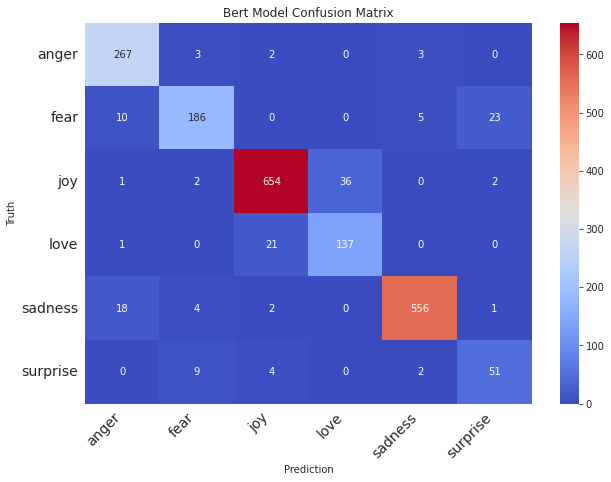

In [214]:
# Bert Evalution
timeData['Evalution(min)']['Bert'] = Bert_elapasedTime_30
F1ModelScores = appendF1ModelScores(testLabels,
                    Bert_predVal_30,
                    F1ModelScores,
                    'Bert')
BertConfusionMatrix = confusion_matrix(testLabels,Bert_predVal_30) 
print_confusion_matrix(val,labels,'Bert Model Confusion Matrix','/models/Stats/BertConfusionMatrix.eps')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


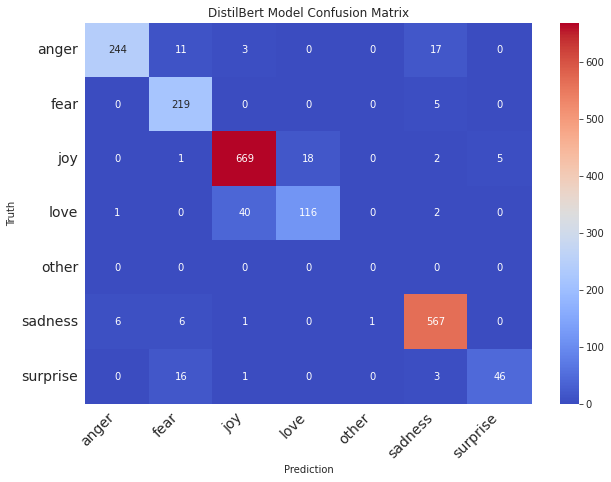

In [248]:
# DistilBert Evalution
timeData['Evalution(min)']['DistilBert'] = DistilBert_elapasedTime_30
F1ModelScores = appendF1ModelScores(list(testData['Label']),
                    DistilBert_predVal_30,
                    F1ModelScores,
                    'DistilBert')
DistilBertConfusionMatrix = confusion_matrix(testLabels,DistilBert_predVal_30) 
print_confusion_matrix(DistilBertConfusionMatrix,labels[0:4]+['other']+[labels[4]]+[labels[5]],'DistilBert Model Confusion Matrix','/models/Stats/DistilBertConfusionMatrix.eps')

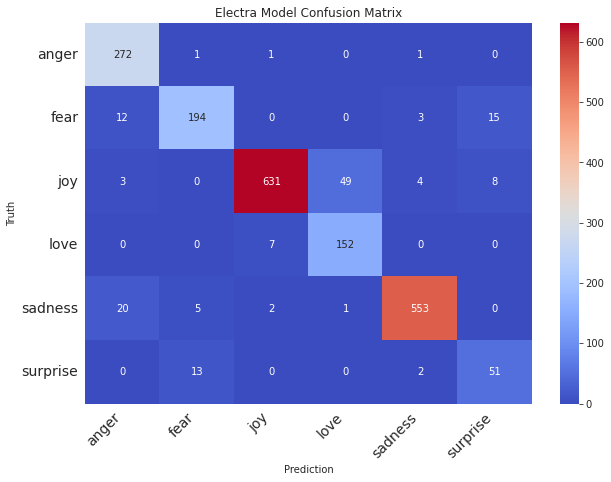

In [249]:
# Electra Evalution
timeData['Evalution(min)']['Electra'] = Electra_elapasedTime_30
F1ModelScores = appendF1ModelScores(list(testData['Label']),
                    Electra_predVal_30,
                    F1ModelScores,
                    'Electra')
ElectraConfusionMatrix = confusion_matrix(testLabels,Electra_predVal_30) 
print_confusion_matrix(ElectraConfusionMatrix,labels,
                       'Electra Model Confusion Matrix',
                       '/models/Stats/ElectraConfusionMatrix.eps')


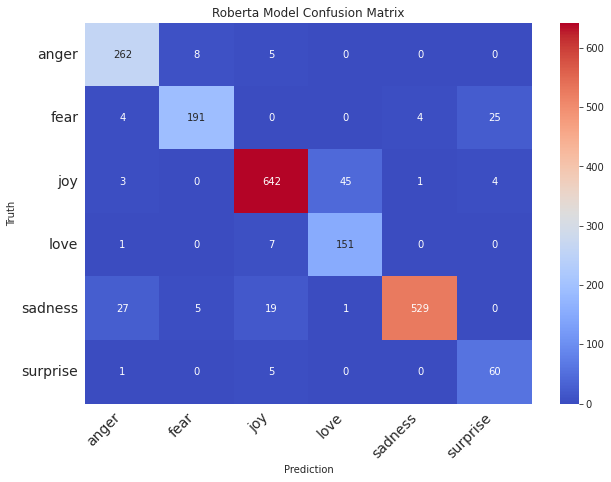

In [250]:
# Roberta Evalution
timeData['Evalution(min)']['Roberta'] = Roberta_elapasedTime_30
F1ModelScores = appendF1ModelScores(list(testData['Label']),
                    Roberta_predVal_30,
                    F1ModelScores,
                    'Roberta')
RobertaConfusionMatrix = confusion_matrix(testLabels,Roberta_predVal_30) 
print_confusion_matrix(RobertaConfusionMatrix,labels,
                       'Roberta Model Confusion Matrix',
                       '/models/Stats/RobertaConfusionMatrix.eps')

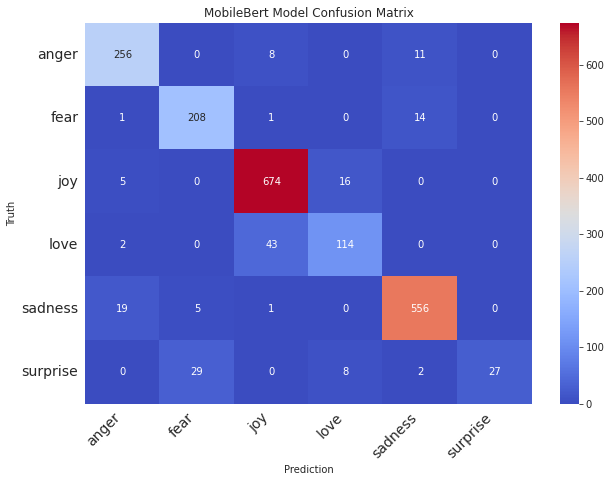

In [251]:
# MobileBert Evalution
timeData['Evalution(min)']['MobileBert'] = MobileBert_elapasedTime_30
F1ModelScores = appendF1ModelScores(list(testData['Label']),
                    MobileBert_predVal_30,
                    F1ModelScores,
                    'MobileBert')
MobileBertConfusionMatrix = confusion_matrix(testLabels,MobileBert_predVal_30) 
print_confusion_matrix(MobileBertConfusionMatrix,labels,
                       'MobileBert Model Confusion Matrix',
                       '/models/Stats/MobileBertConfusionMatrix.eps')

In [252]:
timeData

,Training(min),Evalution(min)
Models,,
Bert,40.030757,2.950655
DistilBert,20.504260,2.414329
Roberta,39.350323,2.994889
Electra,11.444869,2.974098
MobileBert,27.126497,7.924470


In [253]:
F1ModelScores

Emotion,Bert,DistilBert,Electra,Roberta,MobileBert
anger,0.933566,0.927757,0.934708,0.914485,0.917563
fear,0.869159,0.918239,0.887872,0.892523,0.892704
joy,0.949202,0.949610,0.944611,0.935178,0.947961
love,0.825301,0.791809,0.842105,0.848315,0.767677
sadness,0.969486,0.963466,0.966783,0.948879,0.955326
surprise,0.713287,0.786325,0.728571,0.774194,0.580645
accuracy,0.925500,0.930500,0.926500,0.917500,0.917500
macro avg,0.876667,0.762458,0.884108,0.885596,0.843646
weighted avg,0.926344,0.929183,0.928057,0.919318,0.913278


In [30]:
F1ModelScores

Emotion,Bert
anger,0.933566
fear,0.869159
joy,0.949202
love,0.825301
sadness,0.969486
surprise,0.713287
accuracy,0.925500
macro avg,0.876667
weighted avg,0.926344


In [254]:
F1ModelScores.to_csv('/models/Stats/ModelPerformance.csv',index=True,index_label='Emotion')
timeData.to_csv('/models/Stats/TimeData.csv',index=True,index_label='Models')
threshHoldStats.to_csv('/models/Stats/ThreshHoldStats.csv',index=True,index_label='Threshold')

In [40]:
timeData
13550342-124650246

-111099904

In [ ]:
!gsutil cp -r /models/Stats/* gs://emotion-models/Stats/

Copying file:///models/Stats/ModelPerformance.csv [Content-Type=text/csv]...
Copying file:///models/Stats/TimeData.csv [Content-Type=text/csv]...
/ [2 files][  1.2 KiB/  1.2 KiB]                                                
Operation completed over 2 objects/1.2 KiB.                                      
